In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import balanced_accuracy_score
from tsfresh import extract_features, select_features


In [2]:
def plot_array(array, color='blue'):
    if not color == 'blue':
        if color == 1:
            color = 'green'
        else:
            color = 'red'
    plt.figure(figsize=(15, 2))
    plt.plot(array, color=color)
    plt.show()

In [3]:
df_train = pd.read_csv('data/ptbdb_train.csv')
df_test = pd.read_csv('data/ptbdb_test.csv')
X = df_train.iloc[:, :-1].values
y = df_train.iloc[:, -1].values
X_test = df_test.iloc[:, :-1].values
y_test = df_test.iloc[:, -1].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

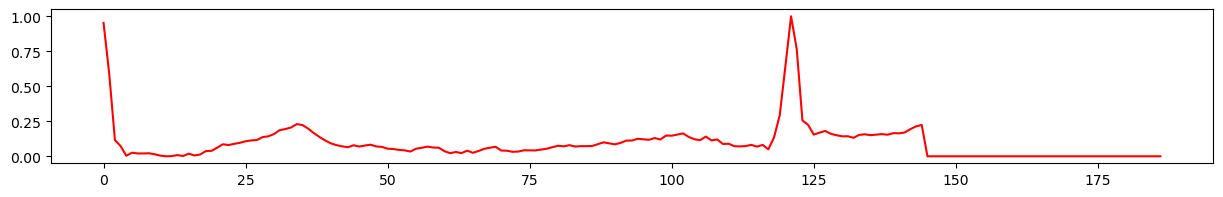

In [4]:
idx = 2
plot_array(X[idx], y[idx])

In [5]:
cls_0 = np.count_nonzero(y == 0)
cls_1 = np.count_nonzero(y == 1)
print(f'Class zero samples: {cls_0}, Class one samples: {cls_1}')
print('Based on this information, we can see that the dataset is imbalanced. We use balanced accuracy as metric.')

Class zero samples: 3237, Class one samples: 8403
Based on this information, we can see that the dataset is imbalanced. We use balanced accuracy as metric.


In [6]:
svm_clf_no_features = svm.SVC()
svm_clf_no_features.fit(X_train, y_train)

svm_preds = svm_clf_no_features.predict(X_val)
svm_acc_no_features = balanced_accuracy_score(y_val, svm_preds)
print(f'SVM balanced accuracy: {svm_acc_no_features}')

rf_clf_no_features = RandomForestClassifier()
rf_clf_no_features.fit(X_train, y_train)

rf_preds = rf_clf_no_features.predict(X_val)
rf_acc_no_features = balanced_accuracy_score(y_val, rf_preds)
print(f'Random Forest balanced accuracy: {rf_acc_no_features}')

SVM balanced accuracy: 0.8631821368142264
Random Forest balanced accuracy: 0.9536559287407341


In [24]:
df_train['id'] = range(len(df_train))
X.shape

(11640, 187)

In [8]:
#extracted_feautures = extract_features(df_train, column_id='id')

RNNs

In [11]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader


In [37]:
def train_model(model, dataloader, epochs=10):
    # Define the loss function and the optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters())

    # Loop over the epochs
    for epoch in range(epochs):
        for inputs, targets in dataloader:
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs).squeeze()

            # Compute the loss
            loss = criterion(outputs, targets)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch+1}/{epochs} Loss: {loss.item()}')
        
def create_dataloader(X, y, batch_size=32):
    # Convert X and y to PyTorch tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)

    # Wrap them in a TensorDataset
    dataset = TensorDataset(X_tensor, y_tensor)

    # Create a DataLoader
    dataloader = DataLoader(dataset, batch_size=batch_size)

    return dataloader

def get_predictions(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    predictions = []

    with torch.no_grad():  # No need to track gradients
        for inputs, _ in dataloader:
            outputs = model(inputs)
            predictions.extend(outputs.detach().numpy())

    return predictions

In [38]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, output_size)


    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc1(out)
        return out

In [39]:
rnn = RNNModel(input_size=187, hidden_size=100, output_size=1)

train_loader = create_dataloader(X_train, y_train)
val_loader = create_dataloader(X_val, y_val)

In [40]:
train_model(rnn, train_loader, epochs=10)

Epoch 1/10 Loss: 0.4177936017513275
Epoch 2/10 Loss: 0.3872130513191223
Epoch 3/10 Loss: 0.36698830127716064
Epoch 4/10 Loss: 0.35270553827285767
Epoch 5/10 Loss: 0.34684616327285767
Epoch 6/10 Loss: 0.3363097310066223
Epoch 7/10 Loss: 0.32617896795272827
Epoch 8/10 Loss: 0.3159714937210083
Epoch 9/10 Loss: 0.30817508697509766
Epoch 10/10 Loss: 0.2942151427268982
